# Analysis - Congressional Fundraising and Votes

### Set-up

In [198]:
#import dependencies
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
#import dataset
data = pd.read_csv('new data.csv')
data['vote'] = [0 for _ in range(len(data))]

#remove candidates for which we have no fundrasing data
data = data[data['amount'] != '0']

#prepare for cleaning
a = np.array(data.as_matrix())
data

,text,amount,vote
0,Alabama District 01,NaN,0
1,Candidate,Candidate Raised,0
2,Bradley Byrne (R) • Incumbent • Winner,1366370,0
3,Alabama District 02,NaN,0
4,Candidate,Candidate Raised,0
5,Martha Roby (R) • Incumbent • Winner,1381821,0
8,Alabama District 03,NaN,0
9,Candidate,Candidate Raised,0
10,Mike D Rogers (R) • Incumbent • Winner,1137285,0
11,Jesse Smith (D),9810,0


### Cleaning

#### Clean Fundraising Data

In [199]:
#trim candidate names
for i in range(len(a)):
    a[i][0] = a[i][0].split(' (')[0]

#split large dataset into small arrays by district
b = np.split(a, (a.transpose()[0] == 'Candidate').nonzero()[0] - 1)
for i in range(len(b)):
    b[i] = b[i][1:]
    #todo: add votes header

#### Clean Voting Data

In [200]:
#read votes data
voting = pd.read_csv('voting2.csv')
v = voting.values
to_del = []
for i in  range(len(v)):
    v[i][0] = v[i][0].split(' (')
    if '%' in v[i][0][1]:
        t = v[i][0][1].split(') ')[1]
        vote = t[:t.index('%')]
        try:
            vote = float(vote)
            if vote < 5:
                to_del.append(i)
            v[i][0][1] = vote
        except ValueError:
            #delete rows for which we don't have vote data
            to_del.append(i)
    else:
        to_del.append(i)
v = np.delete(v, to_del, 0)

#### Match Vote % to Candidates



In [201]:
#todo: make more efficient
for k in range(len(v)):
    for i in range(len(b)):
        if v[k][0][0] in b[i][:,0]:
            for j in range(len(b[i])):
                if v[k][0][0] in b[i][j]:
                    b[i][j][2] = v[k][0][1]

#### Example Chunk

In [202]:
df = pd.DataFrame(b[63])
df
#todo: convert headers

,0,1,2
0,Candidate,Candidate Raised,0
1,Ken Calvert,1443899,58.8
2,Tim Sheridan,138396,41.2


### Calculations

#### Calculate % Raised for Each Candiate in Chunk



791 791 791


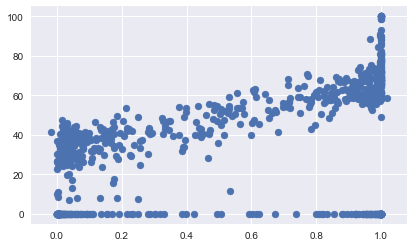

In [218]:
def calc(x):
    total = sum(x[1:][:,1].astype(int))
    spends = [i / total for i in x[1:][:,1].astype(int)]
    votes = x[1:][:,2].astype(float)
    #return list of lists: [% raised, % votes]
    i = [list(a) for a in zip(spends, votes)]
    for j in i:
        j.append(total)
    return i

x = np.array([[0,0, 0]])
for i in range(1, len(b)):
    x = np.concatenate((x, calc(b[i])), axis = 0)
x, y, z = x[:,0], x[:,1], x[:,2]
plt.scatter(x, y)
print(len(x), len(y), len(z))

#### Clean Data

In [219]:
#remove candidates with no votes
x, y, z = x[y!=0], y[y!=0], z[y!=0]
#remove datapoints where 1 candidate raises more than 99.9% of the money (optional)
x, y, z = x[x<.9999], y[x<.9999], z[x<.9999]
x, y, z = x[x>.0001], y[x>.0001], z[x>.0001]
print(len(x), len(y), len(z))
fit = np.polyfit(x,y,1, full = True)

475 475 475


#### Linear Regression

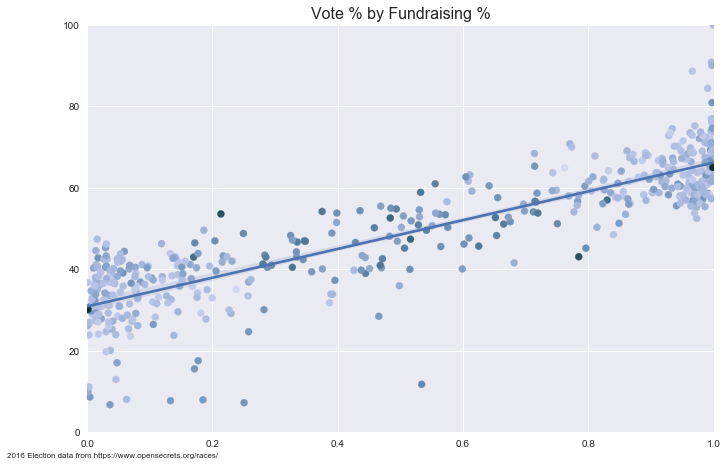

In [220]:
plt.figure(figsize=(10, 7.5))
#plt.annotate(fit[0][1], (0,0), (-80,-20), fontsize=8)
#plot linear regression
plt.ylim(0, 100)
plt.xlim(0, 1)
sns.regplot(x, y, scatter = False, robust = False, n_boot = 100)

#color points by amount raised (darker = more)
#scale z to 1
z1 = z / max(z)
z2 = z1 ** .5
cmap = sns.cubehelix_palette(start = 2.4, rot = .2, as_cmap=True)
plt.scatter(x, y, c=z2, s=50, cmap=cmap)

#add text
plt.title('Vote % by Fundraising %', fontsize=16)
plt.annotate('2016 Election data from https://www.opensecrets.org/races/', (0,0), (-80,-20), fontsize=8, 
             xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()